In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.prediction.AE import AE
from utils.datasets import CIFAR_SR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 100
batch_size = 512
scalefactor = 4
latent_dims = [64]
channels = [32, 64, 128, 256]
in_channels = 3
base_width = 32 // scalefactor
model = AE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, base_width, base_width).to(device)).shape)
summary(model, input_size=(1, in_channels, base_width, base_width))

torch.Size([1, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 3, 32, 32]            --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 32, 8, 8]             128
│    └─Conv2d: 2-2                       [1, 64, 4, 4]             32,832
│    └─Conv2d: 2-3                       [1, 128, 2, 2]            131,200
│    └─Linear: 2-4                       [1, 64]                   32,832
├─AEDecoder: 1-2                         [1, 3, 32, 32]            --
│    └─Linear: 2-5                       [1, 4096]                 266,240
│    └─ConvTranspose2d: 2-6              [1, 128, 8, 8]            524,416
│    └─ConvTranspose2d: 2-7              [1, 64, 16, 16]           131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 32, 32]           32,800
│    └─Conv2d: 2-9                       [1, 3, 32, 32]            99
Total params: 1,151,683
Trainable params: 1,151,683


In [3]:
train_dataset = CIFAR_SR(scale_factor=scalefactor, split='train')
test_dataset = CIFAR_SR(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 50000 training samples, 10000 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = MSELoss()
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [5]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0


    for HR, LR in train_loader:

        optimizer.zero_grad()

        recon_imgs = model(LR)

        loss = criterion(recon_imgs, HR)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f}")
    model.loss.append(total_loss)


Epoch [1/100] | Loss: 3.85
Epoch [2/100] | Loss: 2.06
Epoch [3/100] | Loss: 1.48
Epoch [4/100] | Loss: 1.25
Epoch [5/100] | Loss: 1.13
Epoch [6/100] | Loss: 1.02
Epoch [7/100] | Loss: 0.95
Epoch [8/100] | Loss: 0.92
Epoch [9/100] | Loss: 0.89
Epoch [10/100] | Loss: 0.87
Epoch [11/100] | Loss: 0.85
Epoch [12/100] | Loss: 0.84
Epoch [13/100] | Loss: 0.83
Epoch [14/100] | Loss: 0.82
Epoch [15/100] | Loss: 0.82
Epoch [16/100] | Loss: 0.81
Epoch [17/100] | Loss: 0.81
Epoch [18/100] | Loss: 0.80
Epoch [19/100] | Loss: 0.80
Epoch [20/100] | Loss: 0.80
Epoch [21/100] | Loss: 0.79
Epoch [22/100] | Loss: 0.79
Epoch [23/100] | Loss: 0.79
Epoch [24/100] | Loss: 0.79
Epoch [25/100] | Loss: 0.78
Epoch [26/100] | Loss: 0.78
Epoch [27/100] | Loss: 0.78
Epoch [28/100] | Loss: 0.78
Epoch [29/100] | Loss: 0.78
Epoch [30/100] | Loss: 0.77
Epoch [31/100] | Loss: 0.77
Epoch [32/100] | Loss: 0.77
Epoch [33/100] | Loss: 0.77
Epoch [34/100] | Loss: 0.77
Epoch [35/100] | Loss: 0.77
Epoch [36/100] | Loss: 0.76
E

[]

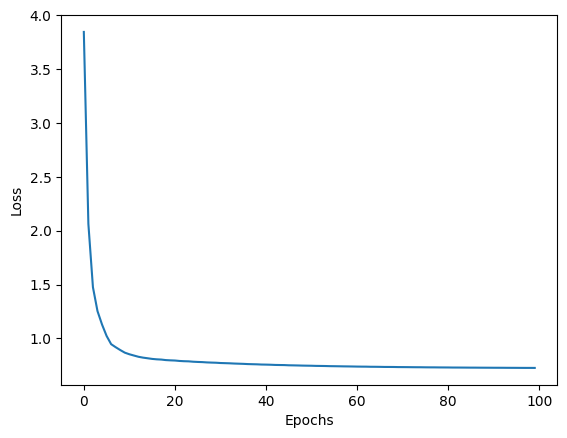

In [6]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [7]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [8]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

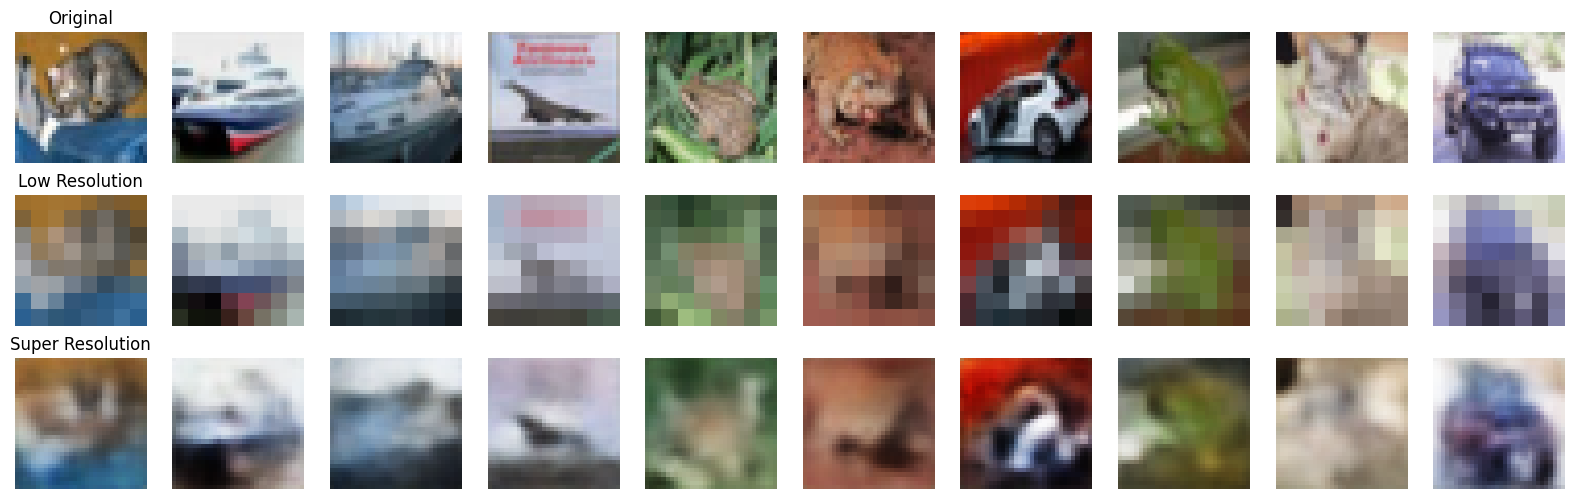

In [9]:
show_image(HR, LR, SR, 10)

In [ ]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

AssertionError: Expected values to be lower or equal to 1.0, got 1.0000001192092896

In [ ]:
#torch.save(model.state_dict(), "AE_CIFAR_4x_prediction_mse.pth")